# CAP 5768 - Data Science - Dr. Marques - Fall 2019

Christian Garbin

## Assignment 6: Regression Analysis
## Starter code

### Goals 

- To learn how to use perform linear regression by least squares using Python and scikit-learn.
- To appreciate that the same linear regression coefficients may be the best fit for dramatically different data distributions -- as illustrated by the Anscombe's quartet.
- To practice with different types of regularization (*lasso* and *ridge*) and understand when to use them.
- To expand upon the prior experience of manipulating, summarizing, and visualizing small datasets.
- To increase our statistical analysis skills.

### Instructions

- This assignment is structured in 4 parts.
- As usual, there will be some Python code to be written and questions to be answered.
- At the end, you should export your notebook to PDF format; it will become your report.
- Submit the report (PDF), notebook (.ipynb file), and (optionally) link to the "live" version of your solution on Google Colaboratory via Canvas.
- The total number of points is 126 (plus up to 60 bonus points).

### Important

- It is OK to attempt the bonus points, but please **do not overdo it!** 

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set()
import scipy.stats as ss

To get more consistent results across runs:

In [2]:
np.random.seed(42)

-------------------
## Part 1: Linear regression by least squares

In this part, we will take another look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the *illiteracy* rate.

The Python code below plots the fertility versus illiteracy and computes the Pearson correlation coefficient. The Numpy array `illiteracy` has the illiteracy rate among females for most of the world's nations. The array `fertility` has the corresponding fertility data.

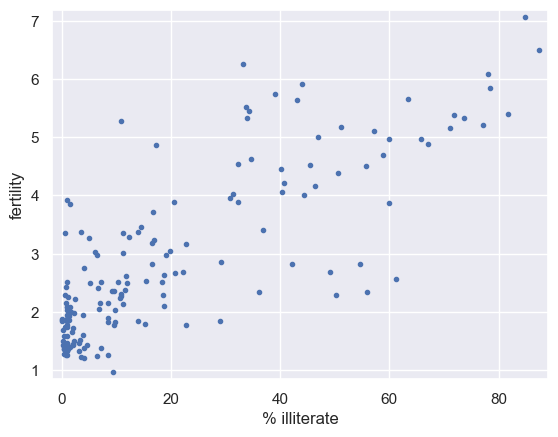

Pearson correlation coefficient between illiteracy and fertility: 0.80413


In [3]:
df = pd.read_csv('data/female_literacy_fertility.csv')

illiteracy = 100 - df['female literacy']

fertility = df['fertility']

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('% illiterate')
_ = plt.ylabel('fertility')

# Show the plot
plt.show()

# Show the Pearson correlation coefficient
print('Pearson correlation coefficient between illiteracy and fertility: {:.5f}'.format(pearson_r(illiteracy, fertility)))

## Your turn! (25 points)

We will assume that fertility is a linear function of the female illiteracy rate: `f=ai+b`, where `a` is the slope and `b` is the intercept. 

We can think of the intercept as the minimal fertility rate, probably somewhere between one and two. 

The slope tells us how the fertility rate varies with illiteracy. 
We can find the best fit line .

Write code to plot the data and the best fit line (using `np.polyfit()`) and print out the slope and intercept.

## Solution

Best fit line (a one-degree polynomial)

In [4]:
line = np.polyfit(illiteracy, fertility, 1)
slope = line[0]
intercept = line[1]

Auxiliary function to plot a line, given the slope and the intercept

In [5]:
# Adapted from https://stackoverflow.com/a/43811762/336802
def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '-')

Plot the best fit line and its values

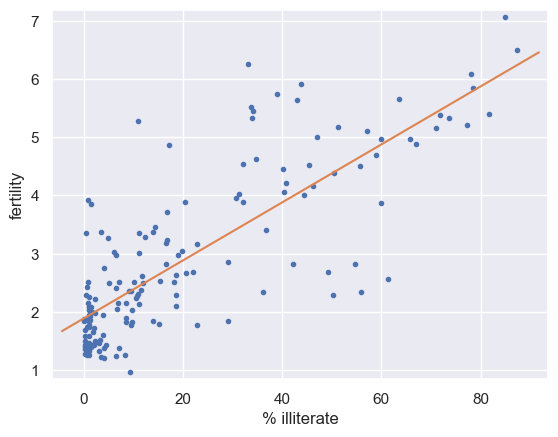

The best fit line has slope 0.05 (children per woman / percent illiteracy) and intercept 1.89 (children per woman)


In [6]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Plot the fit line
abline(plt.gca(), slope, intercept)
    
# Set the margins and label axes
plt.margins(0.02)
_ = plt.xlabel('% illiterate')
_ = plt.ylabel('fertility')

plt.show()

print('The best fit line has slope {:.2f} '
      '(children per woman / percent illiteracy) and intercept {:.2f} '
      '(children per woman)'.format(slope, intercept))

The interpretation of the slope (for this linear model): for each 1% increase in illiteracy, there is a 0.05 child increase in fertility. Or, for every 20% increase in illiteracy, a woman has one additional child (20 * 1% increase in illiteracy ~ 20 * 0.05 = 1 child).

The intercept (also for this linear model) says that this correlation starts at about two children (1.89). We cannot say the same for fewer children than that.

IMPORTANT: this is not (necessarily) causation. It is just correlation at this point.

## BONUS! (15 points)

The function `np.polyfit()` that you used above to get your regression parameters finds the optimal slope and intercept. It is optimizing the the _residual sum of squares (RSS)_, also known as the _sum of squared residuals (SSR)_ or the _sum of squared estimate of errors (SSE)_, which can be defined as "the sum of the squares of residuals (deviations predicted from actual empirical values of data)." (see https://en.wikipedia.org/wiki/Residual_sum_of_squares)

Write code to plot the function that is being optimized, the RSS, versus the slope parameter `a`. To do this, fix the intercept (`b`) to be what you found in the optimization. Then, plot the RSS vs. the slope. Where is it minimal?

Your plot will probably look like this:

![RSS by slope](notebook_images/slope_rss.png)


## Solution

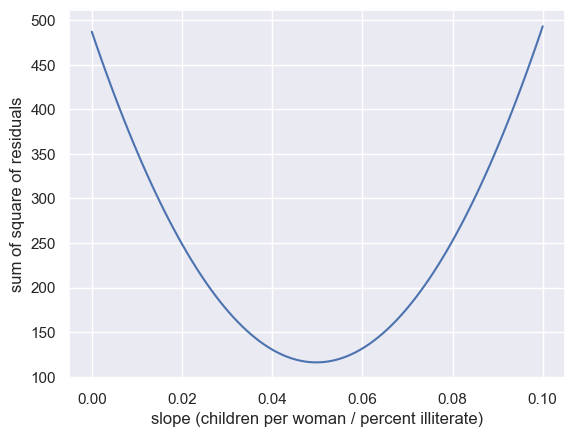

In [7]:
# Slopes values to try
slopes = np.linspace(0, 0.1, 100)

# Compute sum of square of residuals for each value of a_vals
# This could be done in one step with list comprehension; it's done
# in two steps to visualize them: calculate residuals, then square it
rss = np.empty_like(slopes)
for i, slope in enumerate(slopes):
    # Residuals for each point
    residuals = fertility - (slope*illiteracy + intercept)
    # Square them so positive/negative residuals don't cancel each other out
    rss[i] = np.sum(residuals ** 2)

plt.plot(slopes, rss)
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

plt.show()

In [8]:
print(slopes[np.argmin(rss)])

0.049494949494949494


-------------------
## Part 2: Anscombe's quartet

The Anscombe's quartet is a collection of four small data sets that have nearly identical simple descriptive statistics, yet have very different distributions. Each dataset consists of 11 `(x,y)` points. The quartet was created in 1973 by the statistician Francis Anscombe to demonstrate: the importance of visualization and exploratory data analysis (EDA), the effect of outliers and other influential observations on statistical properties, and the limitations of summary statistics (\*).

(\*) See https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story if you're interested.

![Anscombes Quartet](notebook_images/anscombe_quartet.png)

The Python code below performs a linear regression on the data set from Anscombe's quartet that is most reasonably interpreted with linear regression.

In [9]:
x1 = [10.0, 8.0,  13.0,  9.0,  11.0, 14.0, 6.0,  4.0,  12.0,  7.0,  5.0]
y1 = [8.04, 6.95, 7.58,  8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]

x2 = [10.0, 8.0,  13.0,  9.0,  11.0, 14.0, 6.0,  4.0,  12.0,  7.0,  5.0]
y2 = [9.14, 8.14, 8.74,  8.77, 9.26, 8.10, 6.13, 3.10, 9.13,  7.26, 4.74]

x3 = [10.0, 8.0,  13.0,  9.0,  11.0, 14.0, 6.0,  4.0,  12.0,  7.0,  5.0]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15,  6.42, 5.73]

x4 = [8.0,  8.0,  8.0,   8.0,  8.0,  8.0,  8.0,  19.0,  8.0,  8.0,  8.0]
y4 = [6.58, 5.76, 7.71,  8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

slope = 0.5000909090909096
intercept = 3.000090909090908


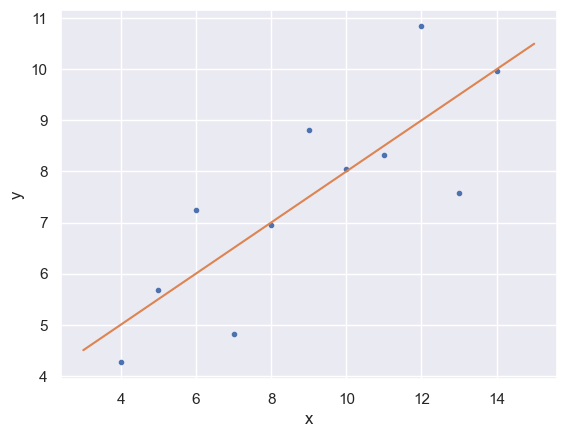

In [10]:
# Perform linear regression: a, b
a, b = np.polyfit(x1, y1, 1)

# Print the slope and intercept
print('slope =', a)
print('intercept =', b)

# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([3, 15])
y_theor = a * x_theor + b

# Plot the Anscombe data and theoretical line
_ = plt.plot(x1, y1, marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor)

# Label the axes
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()

## Your turn! (25 points)

### Linear regression on all Anscombe data

Write code to verify that all four of the Anscombe data sets have the same slope and intercept from a linear regression, i.e. compute the slope and intercept for each set. 

The data are stored in lists (`anscombe_x = [x1, x2, x3, x4]` and `anscombe_y = [y1, y2, y3, y4]`), corresponding to the $x$ and $y$ values for each Anscombe data set.

## Solution

In [11]:
anscombe_x = [x1, x2, x3, x4]
anscombe_y = [y1, y2, y3, y4]

In [12]:
# Fit all quartets
fit_lines =[np.polyfit(x, y, 1) for x, y in zip(anscombe_x, anscombe_y)]

# Show the slope and intercept for each one
for i, line in enumerate(fit_lines, start=1):
    print('Anscombe {}: slope={:.5f}, intercept={:.5f}'.format(
        i, line[0], line[1]))

# Check if they have the same slope and intercept, to a reasonable precision
# Compare them against the expect slope/intercept of the Anscombe's quartet
allclose = np.allclose(fit_lines,
                       list([[0.5, 3.0]] * len(anscombe_x)), rtol=1e-03)

print('The Anscombe\'s quartets have the same slope and intercept: {}'.\
      format(allclose))

Anscombe 1: slope=0.50009, intercept=3.00009
Anscombe 2: slope=0.50000, intercept=3.00091
Anscombe 3: slope=0.49973, intercept=3.00245
Anscombe 4: slope=0.49991, intercept=3.00173
The Anscombe's quartets have the same slope and intercept: True


-------------------
## Part 3: Regression using scikit-learn

Now that we know the basics of linear regression, we will switch to scikit-learn, a powerful, workflow-oriented library for data science and machine learning.

The Python code below shows a simple linear regression example using scikit-learn. Note the use of the `fit()` and `predict()` methods.

[2.9776566]
-1.903310725531119


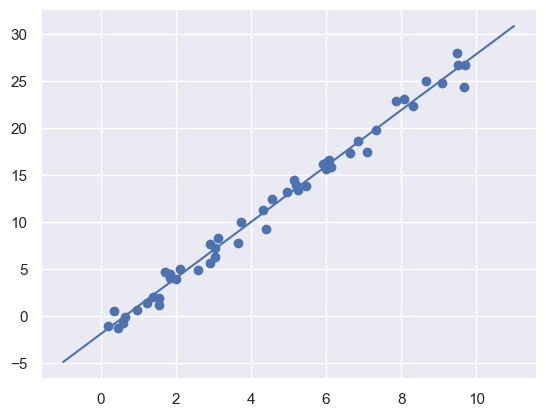

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data around the y = ax+b line where a=3 and b=-2
rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 3 * x - 2 + rng.randn(50)

from sklearn.linear_model import LinearRegression

# Note: If you get a "ModuleNotFoundError: No module named 'sklearn'" error message, don't panic.
# It probably means you'll have to install the module by hand if you're using pip. 
# If you're using conda, you should not see any error message.

model = LinearRegression(fit_intercept=True)

X = x[:, np.newaxis]
X.shape

model.fit(X, y)
print(model.coef_)
print(model.intercept_)

xfit = np.linspace(-1, 11)
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Polynomial regression

One way to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.

The idea is to take the multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

The code below shows a simple example of polynomial regression using the ``PolynomialFeatures`` transformer in scikit-learn. Concretely, it shows how we can use polynomial features with a polynomial of degree seven, i.e. $$y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_7 x^7$$ 

It also introduces the notion of a *pipeline* in scikit-learn. "The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters." (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) 

The R^2 score for the fit is:  0.9806993128749479


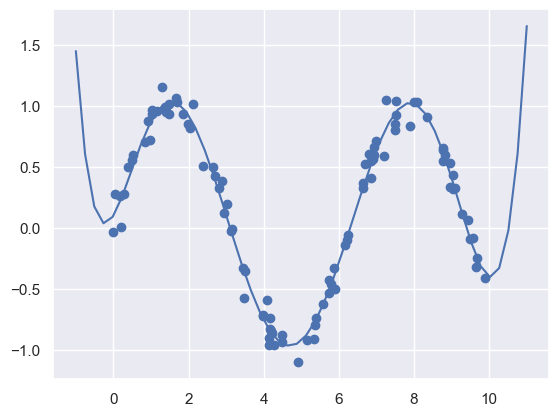

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

rng = np.random.RandomState(1)
x = 10 * rng.rand(100)
y = np.sin(x) + 0.1 * rng.randn(100)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

print('The R^2 score for the fit is: ', poly_model.score(x[:, np.newaxis], y))

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Questions 1-3 (12 points, i.e. 4 pts each)

1. Which mathematical function was used to simulate the data points (with a bit of random noise around them)? 
2. Which degree/order was used for the polynomial basis functions?
3. How good was the linear model fit to the non-linear data?


## Solution

### 1. Which mathematical function was used to simulate the data points (with a bit of random noise around them)?

`numpy.sin()` was used to simulate the data points (with added noise):

`y = np.sin(x) + 0.1 * rng.randn(100)`

### 2. Which degree/order was used for the polynomial basis functions?

A polynomial of order seven:
    
`poly_model = make_pipeline(PolynomialFeatures(7),`

### 3. How good was the linear model fit to the non-linear data?

The $R^2$ score of 0.98 fits the model almost perfectly (given that "[An $R^2$ of 1 indicates that the regression predictions perfectly fit the data](https://en.wikipedia.org/wiki/Coefficient_of_determination#Interpretation)")

## Your turn (18 points)

Write code to find the best degree/order for the polynomial basis functions (between 1 and 15) by computing the quality of the fit using a suitable metric, in this case the $R^2$ coefficient (which can be computer using the `score()` function). 

Remember that **the best possible score is 1.0**. The score can be negative (because the model can be arbitrarily worse). A score of 0 suggests a constant model that always predicts the expected value of y, disregarding the input features.

Hint: If you plot the score against the degree/order of the polynomial, you should see something like this:

![R squared coefficient](notebook_images/r2_coefficient.png)

## Solution

Rebuild the samples because `x` and `y` are commonly used in cells. They could have been inadvertently overwritten above.

In [15]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(100)
y = np.sin(x) + 0.1 * rng.randn(100)

Test different orders/degrees and plot them.

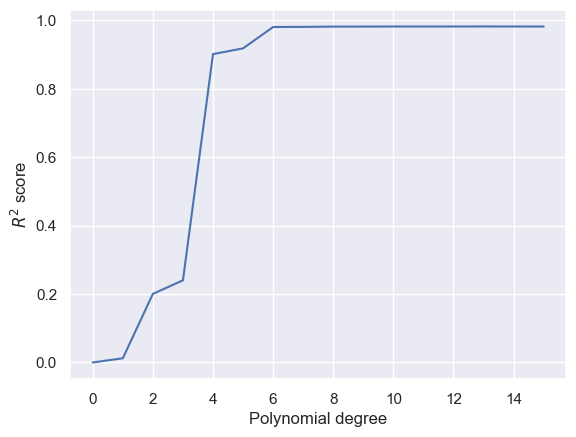

In [16]:
def r2_score(order):
    '''Fit a linear regression model and return its R^2 score.'''
    poly_model = make_pipeline(PolynomialFeatures(order),
                               LinearRegression())
    poly_model.fit(x[:, np.newaxis], y)
    return poly_model.score(x[:, np.newaxis], y)

# Start at zero so the degree matches the index in the array
# Simplifies the code and avoid silly mistakes later
scores = [r2_score(degree) for degree in range(0, 16)]
plt.plot(scores)
plt.ylabel('$R^2$ score')
plt.xlabel('Polynomial degree')
plt.show()

## Questions 4-6 (12 points, i.e. 4 pts each)

4. Which degree/order polynomial produced the best fit (i.e., highest $R^2$ score)? 
5. Would you consider using the resulting polynomial as your model? Why (not)?
6. If you answered 'no' to question 5 (as you should!), which degree would you choose for your polynomial regression model?


## Solution

### 4. Which degree/order polynomial produced the best fit (i.e., highest  𝑅2  score)?

In [17]:
print('Max R^2 score: {:.5f}, for degree {}'.format(
    np.max(scores), np.argmax(scores)))

Max R^2 score: 0.98194, for degree 13


### 5. Would you consider using the resulting polynomial as your model? Why (not)?

No, because that polynomial is overfitting the sample data. It would likely perform poorly on unseen data.

### 6. If you answered 'no' to question 5 (as you should!), which degree would you choose for your polynomial regression model?

I would choose the polynomial of degree six because it is the lowest degree that captures most of the precision of the highest $R^2$ score polynomial (degree 13) found in the tests.

This is visible in the flattening of the line in the graph above when we reach the sixth degree, and analytically in the table below.

In [18]:
max_r2_score = np.max(scores)
for i, score in enumerate(scores):
    print('Degree: {:2d}: score={:.5f}, percent of max R^2 score={:.5f}'. \
          format(i, score, score/max_r2_score))

Degree:  0: score=0.00000, percent of max R^2 score=0.00000
Degree:  1: score=0.01217, percent of max R^2 score=0.01240
Degree:  2: score=0.20041, percent of max R^2 score=0.20410
Degree:  3: score=0.24010, percent of max R^2 score=0.24452
Degree:  4: score=0.90109, percent of max R^2 score=0.91767
Degree:  5: score=0.91790, percent of max R^2 score=0.93478
Degree:  6: score=0.98035, percent of max R^2 score=0.99838
Degree:  7: score=0.98070, percent of max R^2 score=0.99873
Degree:  8: score=0.98154, percent of max R^2 score=0.99959
Degree:  9: score=0.98156, percent of max R^2 score=0.99961
Degree: 10: score=0.98176, percent of max R^2 score=0.99981
Degree: 11: score=0.98176, percent of max R^2 score=0.99981
Degree: 12: score=0.98176, percent of max R^2 score=0.99982
Degree: 13: score=0.98194, percent of max R^2 score=1.00000
Degree: 14: score=0.98177, percent of max R^2 score=0.99983
Degree: 15: score=0.98169, percent of max R^2 score=0.99975


## Part 4: Regularization

The use of polynomial regression with high-order polynomials can very quickly lead to over-fitting. In this part, we will look into the use of regularization to address potential overfitting.

The code below shows an attempt to fit a 15th degree polynomial to a sinusoidal shaped data. The fit is excellent ($R^2$ > 0.98), but might raise suspicions that it will lead to overfitting.

0.9816934216123318


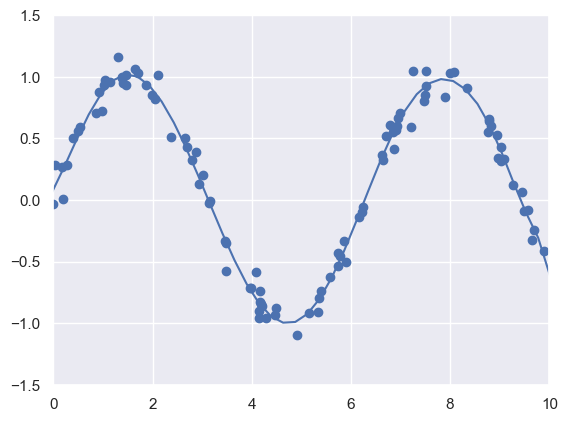

In [19]:
model = make_pipeline(PolynomialFeatures(15),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

score = model.score(x[:, np.newaxis], y)
print(score)

## Your turn! (10 points)

Write Python code to perform Ridge regression ($L_2$ Regularization), plot the resulting fit, and compute the $R^2$ score.

Hints: 
1. This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator. 
2. In the beginning, use all default values for its parameters.
3. After you get your code to work, spend some time trying to fine-tune the model, i.e., experimenting with the regularization parameters.

## Solution

An auxiliary function to apply a polynomial features transformation, followed by the given classifier, then test and plot the results.

In [20]:
def test_classifier(clf):

    # Rebuild the training dataset because we cannot guarantee it
    # hasn't been changed between runs
    rng = np.random.RandomState(1)
    x = 10 * rng.rand(100)
    y = np.sin(x) + 0.1 * rng.randn(100)
    
    # Also rebuild the test dataset
    x_test = np.linspace(-1, 11)

    # sklearn expects 2D arrays for features
    X = x[:, np.newaxis]
    X_test = x_test[:, np.newaxis]

    # Create a two-stage pipeline:
    #  Stage 1: feature transformation to add non-linear features
    #  Stage 2: the classifier (that will work on the tranformed data)
    model = make_pipeline(PolynomialFeatures(15),
                          clf)

    # Run the pipeline to transform/fit the training data
    model.fit(X, y)

    # Predict some sample data with the trained model
    pred = model.predict(X_test)

    # Plot the training data and the predicted data
    plt.scatter(x, y, label='Training data')
    plt.plot(x_test, pred, label='Predicted data')
    plt.legend()

    # Limit graph to the range of the training data
    plt.xlim(0, 10)
    plt.ylim(-1.5, 1.5);

    score = model.score(X, y)
    print(score)
    
    return model

### Using default values

0.9789010867391619


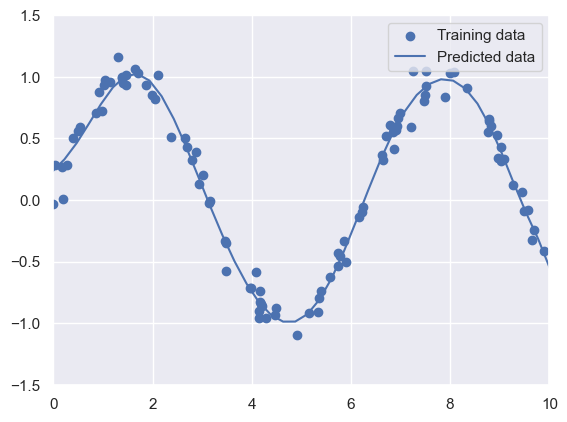

In [21]:
from sklearn.linear_model import Ridge

test_classifier(Ridge(random_state=42));

### Fine tunning parameters

Ridge uses the `alpha` parameter to control the regularization strength. From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html):

> Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.

Therefore, "_fine tunning_" for ridge means _"choose a good alpha value_".

Scikit-learn provides a [`RidgeCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) class that chooses the best value for `alpha`, given a list to test against.

The code below makes use of `RidgeCV()` to pick a value, then plots and scores the model. As a last step, it also shows what alpha value was chosen.

0.981418829747351


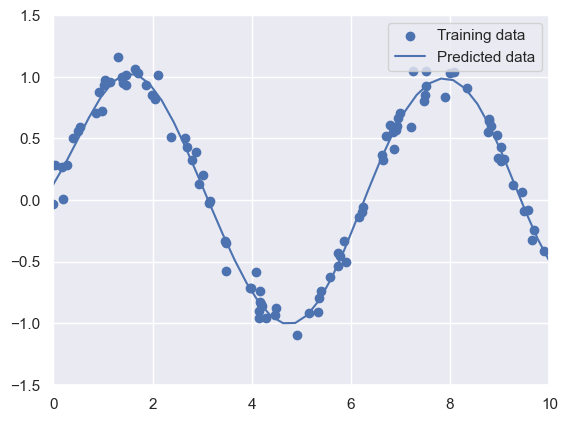

In [22]:
from sklearn.linear_model import RidgeCV

# Note: we need to use an integer value for `cv` - we get a really
# bad-performing classifier with the default value for `cv`
model = test_classifier(RidgeCV([0.05, 0.1, 0.2, 0.3, 0.5], cv=2))

The `alpha` value chosen by `RidgeCV()` (compare with the default value of 1.0, used by `Ridge()` at the time this was written):

In [23]:
print(model[1].alpha_)

0.1


## Your turn! (10 points)

Write Python code to perform Lasso regression ($L_1$ Regularization), plot the resulting fit, and compute the $R^2$ score.

Hints: 
1. This type of penalized model is built into Scikit-Learn with the ``Lasso`` estimator. 
2. In the beginning, use `Lasso(alpha=0.1, tol=0.2)`
3. After you get your code to work, spend some time trying to fine-tune the model, i.e., experimenting with the regularization parameters.

## Solution

### Using default values

0.6754347956467592


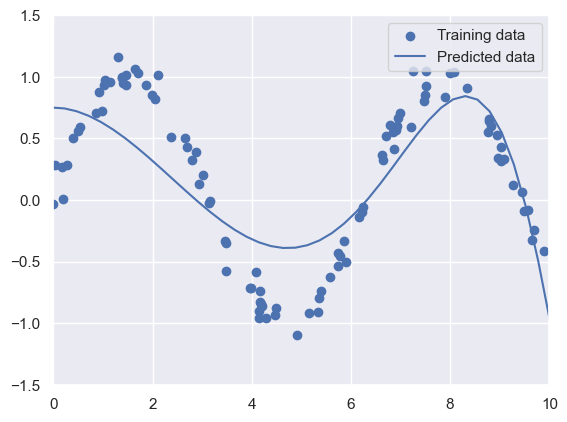

In [24]:
from sklearn.linear_model import Lasso

test_classifier(Lasso(alpha=0.1, tol=0.2));

### Fine tunning parameters

Like the Ridge classifier, the main tunning parameter for the Lasso classifier is the `alpha` parameter.

Also like the `Ridge()` implementation, there is a `LassoCV()` that accepts an array of `alpha` values to test.

However, to get the Lasso classifier to score above 0.8, it was also needed to reduce `tol`, which in turn caused the classifier to complain that it was not convering, which resulted in increasing `max_iter`.

A few more experiments got the classifier above 0.9, but only at the cost of increasing `max_iter` by an order of magnitude or more.

0.8335589733826649


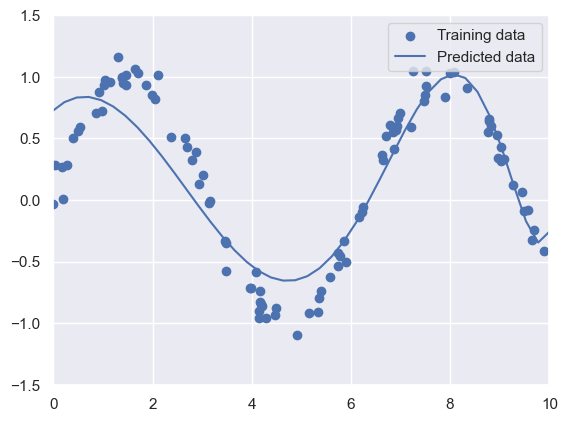

In [25]:
from sklearn.linear_model import LassoCV

model = test_classifier(LassoCV(alphas=[0.01, 0.05, 0.1, 0.5],
                                tol=0.1, cv=5, max_iter=1_000_000));

The `alpha` chosen by `LassoCV()`:

In [26]:
print(model[1].alpha_)

0.01


## Question 7 (4 points)

7. Which of the two regularization approaches produced a better fit (and was also the easiest to fine-tune)?


The Ridge regularization was the easiest one. With only a few tries of different `alpha` values it was able to achieve an $R^2$ score of 0.98. The Lasso regularization, on the other hand, required changes to more parameters (e.g. `tol` and `max_iter`) just to get a score above 0.8.

However, Lasso is able to drive coeffiecients down to zero, while Ridge cannot. If it is important to identify what features are relevant for prediction and fast computation (fewer coefficients), the time invested in finding a well-performing Lasso classifier may be justifiable. ([source 1](https://stats.stackexchange.com/a/876) and [source 2](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)).

## Bonus! (30 points)

The Boston housing dataset is a classic dataset used in linear regression examples.
(See https://scikit-learn.org/stable/datasets/index.html#boston-dataset for more)

The Python code below:
- Loads the Boston dataset (using scikit-learn's `load_boston()`) and converts it into a Pandas dataframe
- Selects two features to be used for fitting a model that will then be used to make predictions: LSTAT (% lower status of the population) and RM (average number of rooms per dwelling) (\*)
- Splits the data into train and test sets

(\*) See https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155 for details.

**NOTE**: This section is no longer maintained because the Boston housing prices dataset has flaws. Refer to the error shown in the cell below.

In [27]:
# Will show an error - see text above
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [ ]:
# boston['MEDV'] = boston_dataset.target
# X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
# y = boston['MEDV']

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

Write Python code to:

1. Fit a linear model to the data.
2. Compute and print the RMSE and $R^2$ score for both train and test datasets.
3. Fit a polynomial model (of degree 4) to the data.
4. Compute and print the RMSE and $R^2$ score for both train and test datasets.
5. Apply Ridge regression to the polynomial model.
4. Compute and print the RMSE and $R^2$ score for both train and test datasets.

## Solution

Disclaimer: this section is heavily influenced by the link provided above, https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155.

A quick look into the dataset.

In [ ]:
# display(X.head(3))

We have two dependent variables, making this case a _multivariate linear regression_ (good explanation and illustration [here](https://towardsdatascience.com/data-science-simplified-part-5-multivariate-regression-models-7684b0489015))

### 1. Fit a linear model to the data

In [ ]:
# lin_model = LinearRegression()
# lin_model.fit(X_train, y_train)

### 2. Compute and print the RMSE and $R^2$ score for both train and test datasets

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score

# def print_model_rmse_r2score(model):
#     y_train_predict = model.predict(X_train)
#     y_test_predict = model.predict(X_test)

#     print('              RMSE    R^2')
#     print('Training set: {:.3f}   {:.3f}'.format(
#         np.sqrt(mean_squared_error(y_train, y_train_predict)),
#         r2_score(y_train, y_train_predict)))
#     print('Testing set:  {:.3f}   {:.3f}'.format(
#        np.sqrt(mean_squared_error(y_test, y_test_predict)),
#        r2_score(y_test, y_test_predict)))

In [ ]:
# print_model_rmse_r2score(lin_model)

### 3. Fit a polynomial model (of degree 4) to the data

In [ ]:
# boston_poly_model = make_pipeline(PolynomialFeatures(4),
#                                   LinearRegression())
# boston_poly_model.fit(X_train, y_train);

### 4. Compute and print the RMSE and $R^2$ score for both train and test datasets

In [ ]:
# print_model_rmse_r2score(boston_poly_model)

### 5. Apply Ridge regression to the polynomial model

In [ ]:
# boston_poly_model_ridge = make_pipeline(PolynomialFeatures(4),
#                                         Ridge())
# boston_poly_model_ridge.fit(X_train, y_train);

### 6. Compute and print the RMSE and $R^2$ score for both train and test datasets.

In [ ]:
# print_model_rmse_r2score(boston_poly_model_ridge)

## Conclusions (10 points)

Write your conclusions and make sure to address the issues below:
- What have you learned from this assignment?
- Which parts were the most fun, time-consuming, enlightening, tedious?
- What would you do if you had an additional week to work on this?

## Solution

### What have you learned from this assignment?

1. Perform linear regression with Numpy `polyfit()`
1. Add features to improve fitting with `PolynomialFeatures()`
1. Perform Linear regression with scikit-learn `LinearRegression()`
1. Perform all steps together with a pipeline
1. Regularize with Ridge and Lasso to prevent overfitting
1. Use `RidgeCV()` and `LassoCV()` for hyperparameter search
1. Evaluate the linear regression results with the $R^2$ score
1. Choose an optimal polynomial degree by comparing $R^2$ scores
1. To not trust only the summary statistics (Anscombe's quartet)

### Which parts were the most fun, time-consuming, enlightening, tedious?

**Fun**

1. Most of it. The only exception was fighting `RidgeCV()` (see below).


**Time consuming**

1. Understand how `PolynomialFeatures()` works. "Hiding" it in a pipeline had the side effect of also hiding how it operates internally. For example, the need to use `fit_transform()` in the test data as well. To better undertsand how it works, I wrote [this notebook](https://github.com/fau-masters-collected-works-cgarbin/cap5768-introduction-to-data-science/blob/master/experiments/feature-transformation-without-pipelines.ipynb) to do linear regression step by step, without a pipeline, making the operations in each step visible.
1. Undestand how `RidgeCV()` works and how important it is to set a value for `cv`.

**Enlightening**

1. How to choose a polynomial degree with $R^2$ score.
1. Anscombe's quartet

**Tedious**

1. None

### What would you do if you had an additional week to work on this?

1. Learn [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and apply it to the Lasso hyperparameter optimization. `LassoCV()` accepts mulitple alphas, but other parameters, such as `tol` and `max_iter`, significantly affect the peformance of the classifier. `LassoCV()` does not accept arrays for them (to perform a grid search). Even with the simpler `RidgeCV()`, grid search could have been used to select a value for `cv`.
1. How to graph a 2D linear regression decision plane.